In [335]:
import pandas as pd
import numpy as np
import altair as alt
from collections import Counter
import NLP
from dataprep.clean import validate_country
import altair as alt
# instantiate one
import spacy 
nlp = spacy.load('en_core_web_sm')
#import geopy.geocoder
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from functools import partial
from tqdm import tqdm
import folium 
import pandas as pd
tqdm.pandas()
import re

import matplotlib.pyplot as plt
import seaborn as sns 
import string 
import nltk
import warnings
%matplotlib inline

In [336]:
df = pd.read_csv('metaverse_tweets.csv')

# Preprocessing the Dataset

Sparese Columns: finding columns that are unpredictive columns 

In [337]:
l = list(df.columns[df.nunique()/len(df) < 0.01])
df = df.drop(l, axis=1)

In [338]:
# from numpy import arange
# import altair as alt

# df = df[['user_followers', 'user_friends', 'user_favourites']]
# data = df.values
# X = data[:, :-1]
# y = data[:, -1]

# print(X.shape, y.shape)

# thresholds = arange(0.0, 0.55, 0.05)

# results = []
# for t in thresholds:
    
#     transform = VarianceThreshold(threshold=t)
    
#     X_sel = transform.fit_transform(X)
#     rows, cols = X_sel.shape
#     n_features = cols
#     print('Threshold=%.2f, Features=%d' % (t, n_features))
    
#     results.append(n_features)
    
# d2 = pd.DataFrame({'threshold': thresholds, 'n_features': results})
# alt.Chart(d2).mark_line().encode(
#     x='threshold',
#     y='n_features')

In [339]:
#Getting rid of duplicates 
df.drop_duplicates(inplace=True)

In [340]:
#remove pattern in the input text
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt

In [341]:
#Removing emoticons from the data using the re model and hard coding values 
def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F" #emoticons
        u"\U0001F300-\U0001F5FF" #symbols & Pictographs
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #flags IOS
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [342]:
#remove twitter handles 
df['clean_tweet'] = np.vectorize(remove_pattern)(df['text'], "@[\w]*")
#remove special characters and numbers 
df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
#remove https 
df['clean_tweet'] = df['clean_tweet'].str.replace("https\S+|www\S+https\S+", " ")
#Removing hashtags
df['clean_tweet'] = df['clean_tweet'].str.replace("#",  "")
#Remove short words
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: " ".join([w for w in x.split() if len(w)>3]))
#removes emojis
df['clean_tweet'] = df['clean_tweet'].map(lambda x: remove_emoji(x))
# lower case
df['clean_tweet'] = df['clean_tweet'].str.lower()

/var/folders/cl/z23bldmj68j_l7xncc6br50h0000gp/T/ipykernel_68553/3673450202.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_tweet'] = df['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
/var/folders/cl/z23bldmj68j_l7xncc6br50h0000gp/T/ipykernel_68553/3673450202.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['clean_tweet'] = df['clean_tweet'].str.replace("https\S+|www\S+https\S+", " ")


In [343]:
#Tokenization pre-processing 
tokenized_tweet = df['clean_tweet'].apply(lambda x: x.split())

In [344]:
# stem the word -> narrow to a single common word
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [stemmer.stem(word) for word in sentence])

#Combine into string 
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
               
df['clean_tweet'] = tokenized_tweet

In [345]:
#!pip install TextBlob

In [346]:
from textblob import TextBlob

def polarity(text):
    return TextBlob(text).sentiment.polarity

df['polarity'] = df['text'].apply(polarity)

In [347]:
def sentiment(label):
    if label <= 0: return 0
    elif label > 0: return 1

df['sentiment'] = df['polarity'].apply(sentiment)

## Exploratory Analysis

In [348]:
#!pip install wordcloud

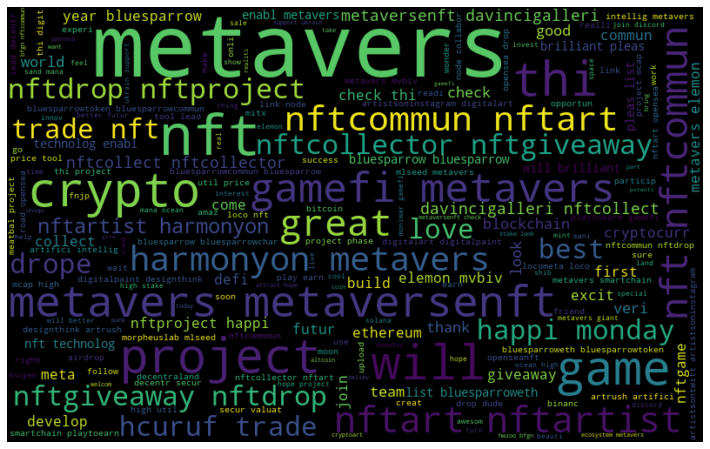

In [349]:
#frequent words positive 
words = " ".join([sentence for sentence in df['clean_tweet'][df['sentiment']== 1]])

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height=500, random_state=42, max_font_size=100).generate(words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

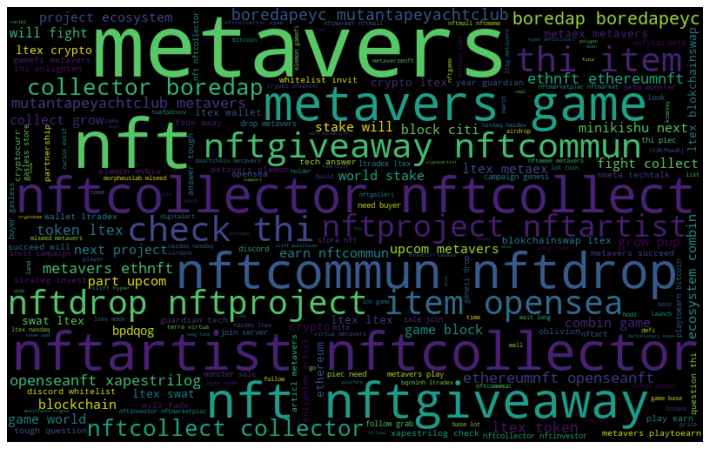

In [350]:
#frequent words negative
words = " ".join([sentence for sentence in df['clean_tweet'][df['sentiment']==0]])

from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height=500, random_state=42, max_font_size=100).generate(words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Split Data

In [351]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(df['clean_tweet'])

In [352]:
bow[0]

<1x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [353]:
#Data Leakage Problem
from sklearn.preprocessing import MaxAbsScaler 

scaler = MaxAbsScaler()
# !!! fitting before the split
bow = scaler.fit_transform(bow) 

In [354]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(bow, df['sentiment'], random_state = 1, test_size = 0.33)

## Model Training 

In [355]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

#Training
model = LogisticRegression()
model.fit(x_train, y_train)

LogisticRegression()

In [356]:
#Testing
pred = model.predict(x_test)
f1_score = f1_score(y_test, pred)
print("f1_score : {:.2f}%".format(f1_score *100))

f1_score : 86.27%


In [357]:
a = accuracy_score(y_test, pred)
print("Test accuracy: {:.2f}%".format(a*100))

Test accuracy: 87.27%


In [358]:
#confusion_matrix(y_test, pred)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       164
           1       0.94      0.80      0.86       166

    accuracy                           0.87       330
   macro avg       0.88      0.87      0.87       330
weighted avg       0.88      0.87      0.87       330

